In [1]:
import os
from pathlib import Path

In [2]:
prompts = [
    "sunrise through a window",
    "a cat in the refrigerator"
]

seed = 10
iterations = 50
terminal_iterations = iterations

# file paths
outpath = "/home/jovyan/work/output/"
# resultspath = "/home/jovyan/work/results/"

resultspath = '/home/jovyan/work/adam_results_test2/'

In [4]:
from pytorch_pretrained_biggan import BigGAN
last_gen_model = 'biggan-deep-512'
biggan_model = BigGAN.from_pretrained(last_gen_model).cuda().eval()


import clip
last_clip_model = 'ViT-B/32'
perceptor, preprocess = clip.load(last_clip_model)
import nltk
nltk.download('wordnet')
import cma
from cma.sigma_adaptation import CMAAdaptSigmaCSA, CMAAdaptSigmaTPA
import warnings
warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# prompt is set above
gen_model = 'biggan-deep' #@param ['biggan-deep', 'sigmoid']
size = '512' #@param [512, 256, 128] 
color = True #@param {type:'boolean'}
initial_class = 'Random mix' #@param ['From prompt', 'Random class', 'Random Dirichlet', 'Random mix', 'Random embeddings'] {allow-input: true}
optimize_class = True #@param {type:'boolean'}
class_smoothing = 0.1 #@param {type:'number'}
truncation = 1 #@param {type:'number'}
stochastic_truncation = False #@param {type:'boolean'}
optimizer = 'CMA-ES' #@param ['SGD','Adam','CMA-ES','CMA-ES + SGD interleaved','CMA-ES + Adam interleaved','CMA-ES + terminal SGD','CMA-ES + terminal Adam']
pop_size = 50 #@param {type:'integer'}
clip_model = 'ViT-B/32' #@param ['ViT-B/32','RN50','RN101','RN50x4']
augmentations =  64#@param {type:'integer'}
learning_rate =  0.1#@param {type:'number'}
noise_normality_loss =  0#@param {type:'number'}
embed_normality_loss = 0 #@param {type:'number'}
minimum_entropy_loss = 0.0001 #@param {type:'number'}
total_variation_loss = 0.1 #@param {type:'number'}
# iterations = 100 #@param {type:'integer'}
# terminal_iterations = 100 #@param {type:'integer'}
show_every = 5 #@param {type:'integer'}
save_every = 5 #@param {type:'integer'}
fps = 1 #@param {type:'number'}
freeze_secs = 0 #@param {type:'number'}
# seed =  1#@param {type:'number'}


softmax_temp = 1
emb_factor = 0.067 #calculated empirically 
loss_factor = 100
sigma0 = 0.5 #http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical
cma_adapt = True
cma_diag = 'sigmoid' in gen_model
cma_active = True
cma_elitist = False


import numpy as np
import torch
from torch import nn
import torchvision
import sys
import imageio
from IPython.display import HTML, Image, clear_output
from scipy.stats import truncnorm, dirichlet
from pytorch_pretrained_biggan import BigGAN, convert_to_images, one_hot_from_names, utils
from nltk.corpus import wordnet as wn
#from base64 import b64encode
from time import time
import datetime

import shutil


In [6]:
if seed == 0:
    seed = None
    state = None
else:
    # torch.manual_seed(np.random.randint(sys.maxsize))
    state = np.random.RandomState(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [7]:
    
# !rm -rf $outpath
# !mkdir -p $outpath
# !mkdir -p $resultspath

shutil.rmtree(outpath)
Path(outpath).mkdir(parents=True, exist_ok=True)
Path(resultspath).mkdir(parents=True, exist_ok=True)


In [8]:
# noise and class vector sizes
noise_size = 128
class_size = 128 if initial_class.lower()=='random embeddings' else 1000

# load CLIP model unless we just used it
if clip_model != last_clip_model:
  perceptor, preprocess = clip.load(clip_model)
  last_clip_model = clip_model
  
# image resolution, model name
channels = 3 if color else 1
clip_res = perceptor.input_resolution.item()
sideX = sideY = int(size)
gen_model = gen_model + '-' + size

# load BigGAN model unless we just used it
if gen_model != last_gen_model and 'biggan' in gen_model:
  biggan_model = BigGAN.from_pretrained(gen_model).cuda().eval()
  last_gen_model = gen_model

# is our image smaller than the clip perceptor?
if sideX<=clip_res and sideY<=clip_res:
  augmentations = 1

# for CMA we produce a population of candidate vectors, otherwise just 1 at a time
if 'CMA' not in optimizer:
  pop_size = 1

# do not optimize class if not using BigGAN
if 'biggan' not in gen_model:
  optimize_class = False

# BigGAN ImageNet class names to WordNet synsets/lemmas
ind2name = {index: wn.of2ss('%08dn'%offset).lemma_names()[0] for offset, index in utils.IMAGENET.items()}

def replace_to_inplace_relu(model): #saves memory; from https://github.com/minyoungg/pix2latent/blob/master/pix2latent/model/biggan.py
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.ReLU(inplace=False))
        else:
            replace_to_inplace_relu(child)
    return

replace_to_inplace_relu(biggan_model)
replace_to_inplace_relu(perceptor)

def save(out,name=None):
  with torch.no_grad():
    out = out.cpu().numpy()
  img = convert_to_images(out)[0]
  if name:
    imageio.imwrite(name, np.asarray(img))
  return img

def save_vec(out,name):
  with torch.no_grad():
    vec = out.cpu().numpy()
  np.savetxt(name, vec)

def save_all_vecs(out, name):
  with torch.no_grad():
    vec = out.cpu().numpy()
  np.savetxt(name, vec)

hist = []
def checkin(i, best_ind, total_losses, losses, regs, out, noise=None, emb=None, probs=None):
  global sample_num, hist
  name = None
  if save_every and i%save_every==0:
    name = '%s/frame_%05d.jpg'%(outpath, sample_num)
  pil_image = save(out, name)
  vals0 = [sample_num, i, total_losses[best_ind], losses[best_ind], regs[best_ind], np.mean(total_losses), np.mean(losses), np.mean(regs), np.std(total_losses), np.std(losses), np.std(regs)]
  stats = 'sample=%d iter=%d best: total=%.2f cos=%.2f reg=%.3f avg: total=%.2f cos=%.2f reg=%.3f std: total=%.2f cos=%.2f reg=%.3f'%tuple(vals0)
  vals1 = []
  if noise is not None:
    vals1 = [np.mean(noise), np.std(noise)]
    stats += ' noise: avg=%.2f std=%.3f'%tuple(vals1)
  vals2 = []
  if emb is not None:
    vals2 = [emb.mean(),emb.std()]
    stats += ' emb: avg=%.2f std=%.3f'%tuple(vals2)
  elif probs:
    best = probs[best_ind]
    inds = np.argsort(best)[::-1]
    probs = np.array(probs)
    vals2 = [ind2name[inds[0]], best[inds[0]], ind2name[inds[1]], best[inds[1]], ind2name[inds[2]], best[inds[2]], np.sum(probs >= 0.5)/pop_size,np.sum(probs >= 0.3)/pop_size,np.sum(probs >= 0.1)/pop_size]
    stats += ' 1st=%s(%.2f) 2nd=%s(%.2f) 3rd=%s(%.2f) components: >=0.5:%.0f, >=0.3:%.0f, >=0.1:%.0f'%tuple(vals2)
  hist.append(vals0+vals1+vals2)
  if show_every and i%show_every==0:
    clear_output()
    display(pil_image)  
  print(stats)
  print('Best index: %s' % best_ind)

  # save best vectors
  save_vec(noise_vector[best_ind], outpath+'noise_%05d.txt'%sample_num)
  save_vec(class_vector[best_ind], outpath+'class_%05d.txt'%sample_num)  
  sample_num += 1

def get_output(noise_vector, class_vector):
  save_class_vector_norm = None
  if 'sigmoid' in gen_model:
    out = noise_vector.sigmoid().reshape(1, channels, sideY, sideX)*2-1
  else:
    if stochastic_truncation: #https://arxiv.org/abs/1702.04782
      with torch.no_grad():
        trunc_indices = noise_vector.abs() > 2*truncation
        size = torch.count_nonzero(trunc_indices).cpu().numpy()
        trunc = truncnorm.rvs(-2*truncation, 2*truncation, size=(1,size)).astype(np.float32)
        noise_vector.data[trunc_indices] = torch.tensor(trunc, requires_grad=requires_grad, device='cuda')
    else:
      noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
    if initial_class.lower() == 'random embeddings':
      class_vector_norm = class_vector*emb_factor
    else:
      class_vector_norm = torch.softmax(class_vector/softmax_temp,dim=-1)
    out = biggan_model(noise_vector, class_vector_norm, truncation)
    if channels==1:
      out = out.mean(dim=1, keepdim=True)
    if initial_class.lower() != 'random embeddings':
      save_class_vector_norm = class_vector_norm
  if channels==1:
    out = out.repeat(1,3,1,1)
  return out, save_class_vector_norm

# define forward pass
def my_forward(self, z, class_label, truncation):
  assert 0 < truncation <= 1

  if initial_class.lower()=='random embeddings':
    embed = class_label
  else:
    embed = self.embeddings(class_label)
    
  cond_vector = torch.cat((z, embed), dim=1)

  z = self.generator(cond_vector, truncation)
  return z

# set forward pass
if gen_model == 'biggan':
    BigGAN.forward = my_forward
    
def normality_loss(vec): #https://arxiv.org/abs/1903.00925
    mu2 = vec.mean().square()
    sigma2 = vec.var()
    return mu2+sigma2-torch.log(sigma2)-1

def make_safe_filename(s):
    def safe_char(c):
        if c.isalnum():
            return c
        else:
            return "_"
    return "".join(safe_char(c) for c in s).rstrip("_")

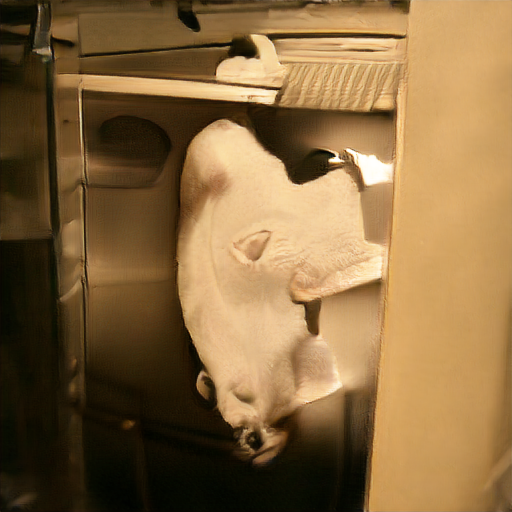

sample=9 iter=45 best: total=65.37 cos=65.31 reg=0.055 avg: total=69.63 cos=69.58 reg=0.055 std: total=2.69 cos=2.69 reg=0.000 noise: avg=-0.10 std=0.963 1st=desktop_computer(0.01) 2nd=missile(0.01) 3rd=lipstick(0.01) components: >=0.5:0, >=0.3:0, >=0.1:0
Best index: 31
took: 1497 secs (32.55 sec/iter) on GPU 0: GeForce RTX 2080 Ti (UUID: GPU-457017a6-9f62-467e-8d27-eb6751fcfb0d). CUDA memory: 2.8 GB
global best iteration: 43
prompt: a cat in the refrigerator


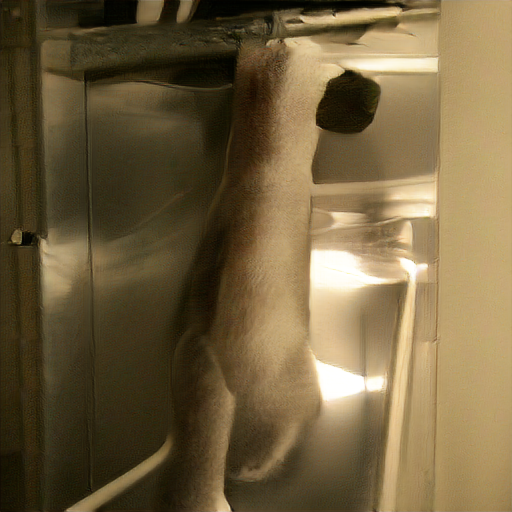

best_loss=64.37 best_iter=47


In [9]:
requires_grad = ('SGD' in optimizer or 'Adam' in optimizer) and ('terminal' not in optimizer or terminal_iterations>0)
total_iterations = iterations + terminal_iterations*('terminal' in optimizer)

# ====
# NOT EDITED BELOW

for prompt in prompts:
    
    # initialization
    eps = 1e-8
    class_vector = None
    if 'sigmoid' in gen_model:
      noise_size = channels*sideY*sideX
      noise_vector = np.random.rand(pop_size, noise_size).astype(np.float32)
      noise_vector = np.log((noise_vector+eps)/(1-noise_vector+eps))
    else:
      noise_vector = truncnorm.rvs(-2*truncation, 2*truncation, size=(pop_size, noise_size), random_state=state).astype(np.float32) #see https://github.com/tensorflow/hub/issues/214

      if initial_class.lower() == 'random class':
        class_vector = np.ones(shape=(pop_size, class_size), dtype=np.float32)*class_smoothing/999
        class_vector[0,np.random.randint(class_size)] = 1-class_smoothing
      elif initial_class.lower() == 'random dirichlet':
        class_vector = dirichlet.rvs([pop_size/class_size] * class_size, size=1, random_state=state).astype(np.float32)
      elif initial_class.lower() == 'random mix':
        class_vector = np.random.rand(pop_size, class_size).astype(np.float32)
      elif initial_class.lower() == 'random embeddings':
        class_vector = np.random.randn(pop_size, class_size).astype(np.float32)
      else:
        if initial_class.lower() == 'from prompt':
          initial_class = prompt
        try:
          class_vector = None
          class_vector = one_hot_from_names(initial_class, batch_size=pop_size)
          assert class_vector is not None
          class_vector = class_vector*(1-class_smoothing*class_size/(class_size-1))+class_smoothing/(class_size-1)
        except Exception as e:  
          print('Error: could not find initial_class. Try something else.')
          raise e

      if initial_class.lower() != 'random embeddings':
        class_vector = class_vector/np.sum(class_vector,axis=-1, keepdims=True)
        class_vector = np.log(class_vector+eps)-np.mean(np.log(class_vector+eps),axis=-1, keepdims=True)
      initial_class_vector = class_vector[0]
      if initial_class.lower() in ('random mix','random embeddings'):
        initial_class_vector = initial_class_vector*0
      class_vector = torch.tensor(class_vector, requires_grad=requires_grad, device='cuda')
      smoothed_ent = -torch.tensor(class_smoothing*np.log(class_smoothing/999+eps)+(1-class_smoothing)*np.log(1-class_smoothing+eps), dtype=torch.float32).cuda()
    noise_vector = torch.tensor(noise_vector, requires_grad=requires_grad, device='cuda')

    if requires_grad:
      params = [noise_vector]
      if optimize_class:
        params = params + [class_vector]
      if 'SGD' in optimizer:
        optim = torch.optim.SGD(params, lr=learning_rate, momentum=0.9)  
      else:
        optim = torch.optim.Adam(params, lr=learning_rate)

    # convert prompt to tokenized target
    tx = clip.tokenize(prompt)
    with torch.no_grad():
      target_clip = perceptor.encode_text(tx.cuda())
    
    # store best results as we optimize this prompt
    global_best_loss = np.inf
    global_best_iteration = 0
    global_best_noise_vector = None
    global_best_class_vector = None

    # ascend the text
    def ascend_txt(i, grad_step=False, show_save=False):
      global global_best_loss, global_best_iteration, global_best_noise_vector, global_best_class_vector
      prev_class_vector_norms = []
      regs = []
      losses = []
      total_losses = []
      best_loss = np.inf
      global_reg = torch.tensor(0, device='cuda', dtype=torch.float32, requires_grad=grad_step)
      if 'biggan' in gen_model:
        if optimize_class and embed_normality_loss and initial_class.lower() == 'random embeddings':
          global_reg = global_reg+embed_normality_loss*normality_loss(class_vector)
        if noise_normality_loss:
          global_reg = global_reg+noise_normality_loss*normality_loss(noise_vector)
        global_reg = loss_factor*global_reg  
        if grad_step:
          global_reg.backward()
      for j in range(pop_size):
        p_s = []
        out, class_vector_norm = get_output(noise_vector[j:j+1], None if class_vector is None else class_vector[j:j+1])
        if class_vector_norm is not None:
          with torch.no_grad():
            prev_class_vector_norms.append(class_vector_norm.cpu().numpy()[0])

        for aug in range(augmentations):
          if sideX<=clip_res and sideY<=clip_res or augmentations==1:
            apper = out  
          else:
            size = torch.randint(int(.7*sideX), int(.98*sideX), ())
            offsetx = torch.randint(0, sideX - size, ())
            offsety = torch.randint(0, sideX - size, ())
            apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
          apper = (apper+1)/2
          apper = nn.functional.interpolate(apper, clip_res, mode='bilinear')
          #apper = apper.clamp(0,1)
          p_s.append(apper)
        into = nom(torch.cat(p_s, 0))
        predict_clip = perceptor.encode_image(into)
        loss = loss_factor*(1-torch.cosine_similarity(predict_clip, target_clip).mean())
        
#         print("tokens:", tx)
#         print("target clip:", target_clip)
#         print("predict clip:",predict_clip)
#         print("cosine_sim:", torch.cosine_similarity(predict_clip, target_clip).mean())
#         sys.exit()

        total_loss = loss
        regs.append(global_reg.item())
        if 'sigmoid' in gen_model and total_variation_loss or 'biggan' in gen_model and optimize_class and minimum_entropy_loss and initial_class.lower() != 'random embeddings':
          if 'sigmoid' in gen_model and total_variation_loss:
            reg = total_variation_loss*((out[:, :, :-1, :] - out[:, :, 1:, :]).abs().mean() + (out[:, :, :, :-1] - out[:, :, :, 1:]).abs().mean())
          elif 'biggan' in gen_model and optimize_class and minimum_entropy_loss and initial_class.lower() != 'random embeddings':
            reg = minimum_entropy_loss*((-class_vector_norm*torch.log(class_vector_norm+eps)).sum()-smoothed_ent).abs()
          reg = loss_factor*reg
          total_loss = total_loss + reg
          with torch.no_grad():
            regs[-1] += reg.item()
        with torch.no_grad():
          losses.append(loss.item())
          total_losses.append(total_loss.item()+global_reg.item())
        if total_losses[-1]<best_loss:
          best_loss = total_losses[-1]
          best_ind = j
          best_out = out
          if best_loss < global_best_loss:
            global_best_loss = best_loss
            global_best_iteration = i
            with torch.no_grad():
              global_best_noise_vector = noise_vector[best_ind]
              if class_vector is not None:
                global_best_class_vector = class_vector[best_ind]

        if grad_step:    
          total_loss.backward()

      if grad_step:
        optim.step()
        optim.zero_grad()

      if show_save and (save_every and i % save_every == 0 or show_every and i % show_every == 0):
        noise = None
        emb = None
        if 'biggan' in gen_model:
          with torch.no_grad():
            noise = noise_vector.cpu().numpy()
            if initial_class.lower() == 'random embeddings':
              emb = class_vector.cpu().numpy()
        checkin(i, best_ind, total_losses, losses, regs, best_out, noise, emb, prev_class_vector_norms)  
      return total_losses, best_ind

    nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    if 'CMA' in optimizer:
      initial_vector = np.zeros(noise_size)
      bounds = None
      #if 'biggan' in gen_model and not stochastic_truncation:
      #  bounds = [-2*truncation*np.ones(noise_size),2*truncation*np.ones(noise_size)]
      if optimize_class:
        initial_vector = np.hstack([initial_vector, initial_class_vector])
        #if not stochastic_truncation:
        #  bounds[0] = list(bounds[0]) + [None]*class_size
        #  bounds[1] = list(bounds[1]) + [None]*class_size
      cma_opts = {'popsize': pop_size, 'seed': np.nan, 'AdaptSigma': cma_adapt, 'CMA_diagonal': cma_diag, 'CMA_active': cma_active, 'CMA_elitist':cma_elitist, 'bounds':bounds}
      cmaes = cma.CMAEvolutionStrategy(initial_vector, sigma0, inopts=cma_opts)

    sample_num = 0
    machine = !nvidia-smi -L
    start = time()
    for i in range(total_iterations):    
      if 'CMA' in optimizer and i<iterations:
        with torch.no_grad():
          cma_results = torch.tensor(cmaes.ask(), dtype=torch.float32).cuda()
          if optimize_class:
            noise_vector.data, class_vector.data = torch.split_with_sizes(cma_results, (noise_size, class_size), dim=-1)
            class_vector.data = class_vector.data
          else:
            noise_vector.data = cma_results      
      if requires_grad and ('terminal' not in optimizer or i>=iterations):
        losses, best_ind = ascend_txt(i, grad_step=True, show_save='CMA' not in optimizer or i>=iterations)
        assert noise_vector.requires_grad and noise_vector.is_leaf and (not optimize_class or class_vector.requires_grad and class_vector.is_leaf), (noise_vector.requires_grad, noise_vector.is_leaf, class_vector.requires_grad, class_vector.is_leaf)
      if 'CMA' in optimizer and i<iterations:
        with torch.no_grad():
          losses, best_ind = ascend_txt(i, show_save=True)
          if i<iterations-1:
            if optimize_class:
              vectors = torch.cat([noise_vector,class_vector], dim=1)
            else:
              vectors = noise_vector
            cmaes.tell(vectors.cpu().numpy(), losses)
          elif 'terminal' in optimizer and terminal_iterations:
            pop_size = 1
            noise_vector[0] = global_best_noise_vector
            if class_vector is not None:
              class_vector[0] = global_best_class_vector
      if save_every and i % save_every == 0 or show_every and i % show_every == 0:
        print('took: %d secs (%.2f sec/iter) on %s. CUDA memory: %.1f GB'%(time()-start,(time()-start)/(i+1), machine[0], torch.cuda.max_memory_allocated()/1024**3))
        print('global best iteration: %d' % global_best_iteration)
        print('prompt: %s' % prompt)
        #print('prompt: %s, target-CLIP: %s' % (prompt, target_clip))

    # from modified BigCLIP
    # prompt_safe = prompt.replace(" ","_")
    # results_timestamp = resultspath+'%s_%s' % (prompt_safe, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
    # save(best_out, results_timestamp+'.jpg')
    # save_vec(noise_vector[best_ind], results_timestamp+'_noise.txt')
    # save_vec(class_vector[best_ind], results_timestamp+'_class.txt')

#     prompt_safe = prompt.replace(" ","_")
    prompt_safe = make_safe_filename(prompt)
    out, _ = get_output(global_best_noise_vector.unsqueeze(0), None if global_best_class_vector is None else global_best_class_vector.unsqueeze(0))
    name = '%s/%s.jpg'%(resultspath, prompt_safe)
    pil_image = save(out,name)
    save_vec(global_best_noise_vector, '%s/%s_noise.txt' % (resultspath, prompt_safe))
    save_vec(global_best_class_vector, '%s/%s_class.txt' % (resultspath, prompt_safe))

    display(pil_image)  
    print('best_loss=%.2f best_iter=%d'%(global_best_loss,global_best_iteration))

    # move outputs to saved path with datestampt
    newdir = outpath[:-1]+"_"+prompt_safe+"_"+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
#     !mv $outpath $newdir
    shutil.move(outpath, newdir)
#     !mkdir -p $outpath
    Path(outpath).mkdir(parents=True, exist_ok=True)

In [38]:
bruh = os.system('nvidia-smi -L')

0

In [39]:
display

<function IPython.core.display.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, **kwargs)>

## Generate from stored stuff

In [15]:
from IPython.display import HTML, clear_output
from PIL import Image
from IPython.display import Image as JupImage
import numpy as np
import nltk
from scipy.stats import truncnorm
import glob

# from biggan
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, convert_to_images) #, display_in_terminal)
import logging
logging.basicConfig(level=logging.WARNING)

# do we need wordnet?
nltk.download('wordnet')

# load biggan
model = BigGAN.from_pretrained('biggan-deep-512')
print("loaded bigGAN")

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


loaded bigGAN


In [18]:
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
import os
import glob

# from
# https://discuss.pytorch.org/t/help-regarding-slerp-function-for-generative-model-sampling/32475/4

# spherical linear interpolation (slerp)
def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = slerp(ratio, p1, p2)
        vectors.append(v)
    return np.asarray(vectors)

In [11]:
# np.random.RandomState(1)
# np.random.seed(1)
# torch.manual_seed(1)

# one random variable
truncation = 1.0

# the file directories
# resultsbase = '/home/jovyan/work/results_tarragon2/'
# workbase = '/home/jovyan/work/'
# interpbase = '/home/jovyan/work/interpolation_tarragon2'
# moviefilename = 'tarragon2_%s.mp4'

# resultsbase = '/home/jovyan/work/results_adam_test/'
# resultsbase = '/home/jovyan/work/'
resultsbase = '/home/jovyan/work/adam_results_test2/'

workbase = '/home/jovyan/work/'
interpbase = '/home/jovyan/work/interpolation_adam_test'
# interpbase = '/home/jovyan/work'
moviefilename = 'adam_test_%s.mp4'

In [31]:



# the interpolation
num_steps = 90#300
len_hold = 30

# the movie
fps = 30


prompts = [
    "sunrise through a window",
    "a cat in the refrigerator"
]


def make_safe_filename(s):
    def safe_char(c):
        if c.isalnum():
            return c
        else:
            return "_"
    return "".join(safe_char(c) for c in s).rstrip("_")

safe_prompts = [make_safe_filename(prompt) for prompt in prompts]

print(safe_prompts)

def get_class_file(path, prompt):
#     result = glob.glob(path+'%s*_class.txt'%prompt)
    print(path+'%s*_class.txt'%prompt)
#     result = glob.glob(path+'%s*_class.txt'%prompt, recursive=True)
#     result = glob.glob(os.path.join(path, '**/', '%s*_class.txt'%prompt))
    result = glob.glob(path+'%s*_class.txt'%prompt)
    return(result)

def get_noise_file(path, prompt):
    print(path+'%s*_noise.txt'%prompt)
#     result = glob.glob(path+'%s*_noise.txt'%prompt, recursive=True)
#     result = glob.glob(os.path.join(path, '**/','%s*_noise.txt'%prompt))
    
    result = glob.glob(path+'%s*_noise.txt'%prompt)
    
    return(result)

# !mkdir -p $interpbasedef get
Path(interpbase).mkdir(parents=True, exist_ok=True)

# print(get_class_file(workbase, safe_prompts[0]))
# print(get_noise_file(workbase, safe_prompts[0]))

['sunrise_through_a_window', 'a_cat_in_the_refrigerator']


In [32]:
class_filenames = [get_class_file(resultsbase, prompt)[0] for prompt in safe_prompts]
noise_filenames = [get_noise_file(resultsbase, prompt)[0] for prompt in safe_prompts]

print(class_filenames, noise_filenames)

print()


class_inputs = [np.loadtxt(filename) for filename in class_filenames]
noise_inputs = [np.loadtxt(filename) for filename in noise_filenames]
# print(class_inputs, noise_inputs)
# print(class_inputs[20])

/home/jovyan/work/adam_results_test2/sunrise_through_a_window*_class.txt
/home/jovyan/work/adam_results_test2/a_cat_in_the_refrigerator*_class.txt
/home/jovyan/work/adam_results_test2/sunrise_through_a_window*_noise.txt
/home/jovyan/work/adam_results_test2/a_cat_in_the_refrigerator*_noise.txt
['/home/jovyan/work/adam_results_test2/sunrise_through_a_window_class.txt', '/home/jovyan/work/adam_results_test2/a_cat_in_the_refrigerator_class.txt'] ['/home/jovyan/work/adam_results_test2/sunrise_through_a_window_noise.txt', '/home/jovyan/work/adam_results_test2/a_cat_in_the_refrigerator_noise.txt']



In [33]:
class_inputs[0].shape

(1000,)

In [34]:
noise_inputs[0].shape

(128,)

In [36]:
count = 0

for i in range(len(class_inputs)):

    # generate interpolations
    noises = interpolate_points(noise_inputs[i], noise_inputs[(i+1)%len(class_inputs)], num_steps)
    classes = interpolate_points(class_inputs[i], class_inputs[(i+1)%len(class_inputs)], num_steps)

    # generate images in batches
    batch_size = 10 # 50
    for j in range(0, num_steps, batch_size):
        clear_output()
        print(i, j, count)
        noise_vector = noises[j:j+batch_size]
        class_vector = classes[j:j+batch_size]

        # convert to tensors
        noise_vector = torch.tensor(noise_vector, dtype=torch.float32)
        class_vector = torch.tensor(class_vector, dtype=torch.float32)

        # put everything on cuda (GPU)
        noise_vector = noise_vector.to('cuda')
        noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
        class_vector = class_vector.to('cuda')
        class_vector = class_vector.softmax(dim=-1)
        model.to('cuda')

        # generate images
        with torch.no_grad():
            print(noise_vector.shape)
            print(class_vector.shape)
            output = model(noise_vector, class_vector, truncation)

        # If you have a GPU put back on CPU
        output = output.to('cpu')

        imgs = convert_to_images(output)

        # repeat first image
        
        if j == 0:
            for k in range(len_hold):
                imgs[0].save(interpbase+"/output_%05d.png" % count)
                count = count + 1
                
        for img in imgs: 
            img.save(interpbase+"/output_%05d.png" % count)
            count = count + 1

1 80 230
torch.Size([10, 128])
torch.Size([10, 1000])


In [37]:
# generate mp4
out = moviefilename%fps
with open('list.txt','w') as f:
  for i in range(count):
    print('file %s/output_%05d.png\n'%(interpbase, i))
    f.write('file %s/output_%05d.png\n'%(interpbase, i))
# !ffmpeg -r $fps -f concat -safe 0 -i list.txt -c:v libx264 -pix_fmt yuv420p -profile:v baseline -movflags +faststart -r $fps $out -y
# !echo ffmpeg -r $fps -f concat -safe 0 -i list.txt -c:v libx264 -pix_fmt yuv420p -profile:v baseline -movflags +faststart -r $fps $out -y
print("ffmpeg -r {0} -f concat -safe 0 -i list.txt -c:v libx264 -pix_fmt yuv420p -profile:v baseline -movflags +faststart -r {0} {1} -y".format(fps, out))
os.system("ffmpeg -r {0} -f concat -safe 0 -i list.txt -c:v libx264 -pix_fmt yuv420p -profile:v baseline -movflags +faststart -r {0} {1} -y".format(fps, out))

# # # rename jpg
# # frame = 'frame_%05d.jpg'%(sample_num-1)
# # jpg = '%s.jpg'%prompt.replace(" ", "_")
# # !cp $frame $jpg
print("ffmpeg -r {0} -f concat -safe 0 -i list.txt -c:v libx264 -pix_fmt yuv420p -profile:v baseline -movflags +faststart -r {0} {1} -y".format(fps, out))

file /home/jovyan/work/interpolation_adam_test/output_00000.png

file /home/jovyan/work/interpolation_adam_test/output_00001.png

file /home/jovyan/work/interpolation_adam_test/output_00002.png

file /home/jovyan/work/interpolation_adam_test/output_00003.png

file /home/jovyan/work/interpolation_adam_test/output_00004.png

file /home/jovyan/work/interpolation_adam_test/output_00005.png

file /home/jovyan/work/interpolation_adam_test/output_00006.png

file /home/jovyan/work/interpolation_adam_test/output_00007.png

file /home/jovyan/work/interpolation_adam_test/output_00008.png

file /home/jovyan/work/interpolation_adam_test/output_00009.png

file /home/jovyan/work/interpolation_adam_test/output_00010.png

file /home/jovyan/work/interpolation_adam_test/output_00011.png

file /home/jovyan/work/interpolation_adam_test/output_00012.png

file /home/jovyan/work/interpolation_adam_test/output_00013.png

file /home/jovyan/work/interpolation_adam_test/output_00014.png

file /home/jovyan/work/in